# Predicting annual temperature change to help address the Climate Change goals for Sustainable Development

## Import necessary libraries and modules

In [1]:
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pennylane as qml
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

## Data Preparation

1. **Initialization:** Initialize empty lists to store data: `prev_years` and `final_years`. These lists have two sub-lists, one for temperature change data and the other for total number of disasters.

2. **Load Temperature Change Data:** Load temperature change data from the "Annual_Surface_Temperature_Change.csv" file. The code reads and processes the data, converting it into numerical values and storing it in the corresponding sub-list of `prev_years`. The final temperature values are stored in the corresponding sub-list of `final_years`.

3. **Load Disaster Data:** Load total number of disasters data from the "disastors.csv" file. The code reads and filters the data based on specific conditions, and the processed data is added to the appropriate sub-lists in `prev_years` and `final_years`.

4. **Conversion to PyTorch Tensors:** Convert the Python lists (`prev_years` and `final_years`) into PyTorch tensors. This conversion prepares the data for machine learning tasks.

5. **Data Splitting:** Split the data into training and test sets. `training_data` and `test_data` are created to store specific subsets of the original data, while `training_labels` and `test_labels` are assigned for the respective final values.

6. **Data Normalization:** Normalize the data to ensure all features have the same scale for better training. A `normalise` function is applied to the data for both training and test sets. The function scales the data between 0 and 1, and the maximum and minimum values are printed for reference.

The code thus prepares and organizes the data for subsequent machine learning tasks and ensures it is in a suitable format for training and evaluation.


In [2]:

# Initialize empty lists to store data
prev_years = [[],[]]
final_years = [[],[]]

# Load temperature change data
with open('./data/Annual_Surface_Temperature_Change.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        temperature_data = [float(val) if val else 0.0 for val in row[35:-1]]
        final_temperature = float(row[-1]) if row[-1] else 0.0
        prev_years[0].append(temperature_data)
        final_years[0].append(final_temperature)

# Load total number of disasters data
with open("./data/disastors.csv", 'r', newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter='\t') 

    for row in csvreader:
        if row[4] == 'Total disasters' and row[5] == 'Number of':
            disasters_data = [float(val) if val else 0.0 for val in row[6:-1]]
            final_disasters = float(row[-1]) if row[-1] else 0.0
            prev_years[1].append(disasters_data)
            final_years[1].append(final_disasters)

# Convert the lists to PyTorch tensors
prev_years = torch.tensor(prev_years, dtype=torch.float64)
final_years = torch.tensor(final_years, dtype=torch.float64)

training_data = prev_years[:,:150,:]
test_data = prev_years[:,150:,:]

training_labels = final_years[:,:150]
test_labels = final_years[:,150:]

print("training data    ",training_data.shape)
print("test data        ",test_data.shape)
print("training labels  ",training_labels.shape)
print("test labels      ",test_labels.shape)

# Normalize the data by scaling it between 0 and 1
# This ensures that all features have the same scale for better training
def normalise(data):
    max = torch.max(data)
    min = torch.min(data)
    data = (data - min)/(max-min)
    print(f"Normalised data, max={max}, min={min}")
    return data

# Normalize training and test data and labels
training_data[0] = normalise(training_data[0])
training_data[1] = normalise(training_data[1])

test_data[0] = normalise(test_data[0])
test_data[1] = normalise(test_data[1])

training_labels[0] = normalise(training_labels[0])
training_labels[1] = normalise(training_labels[1])

test_labels[0] = normalise(test_labels[0])
test_labels[1] = normalise(test_labels[1])

training data     torch.Size([2, 150, 30])
test data         torch.Size([2, 50, 30])
training labels   torch.Size([2, 150])
test labels       torch.Size([2, 50])
Normalised data, max=3.691, min=-1.31
Normalised data, max=34.0, min=0.0
Normalised data, max=3.026, min=-1.12
Normalised data, max=43.0, min=0.0
Normalised data, max=2.929, min=-1.305
Normalised data, max=14.0, min=0.0
Normalised data, max=2.798, min=-0.49
Normalised data, max=25.0, min=0.0


## Data Visualization

1. **Import Libraries:** The code begins by importing the necessary libraries, including `matplotlib.pyplot` as `plt` and `numpy` as `np`, for data visualization.

2. **Temperature Data Visualization:** The code creates a figure with a specified size (12x6) using `plt.figure()`. Within this figure, it defines a subplot grid with 1 row and 2 columns, using `plt.subplot(1, 2, 1)`. This grid layout allows for two side-by-side plots.

3. **Temperature Data Plot:** In the first subplot, it uses `plt.imshow()` to display the temperature data (`prev_years[0]`) as an image, using a colormap 'coolwarm'. The `aspect` parameter is set to 'auto' to ensure that the plot adjusts aspect ratio automatically. The plot is given a title 'Temperature Data', and a colorbar is added to indicate temperature values. The x-axis is labeled as "Years," and the y-axis is labeled as "Countries."

4. **Disaster Counts Visualization:** In the second subplot, the code follows a similar approach to visualize disaster counts. It uses `plt.imshow()` to display the disaster data (`prev_years[1]`) with a 'viridis' colormap. The aspect ratio is adjusted automatically ('auto'). The plot is titled 'Disaster Counts,' and a colorbar is included to represent the count values. The x-axis is labeled as "Years," and the y-axis is labeled as "Countries."

5. **Display Visualization:** Finally, `plt.show()` is used to display the entire figure, which shows both temperature data and disaster counts side by side.

This code segment is responsible for visually representing the temperature and disaster count data in two separate plots within the same figure, aiding in data exploration and analysis.


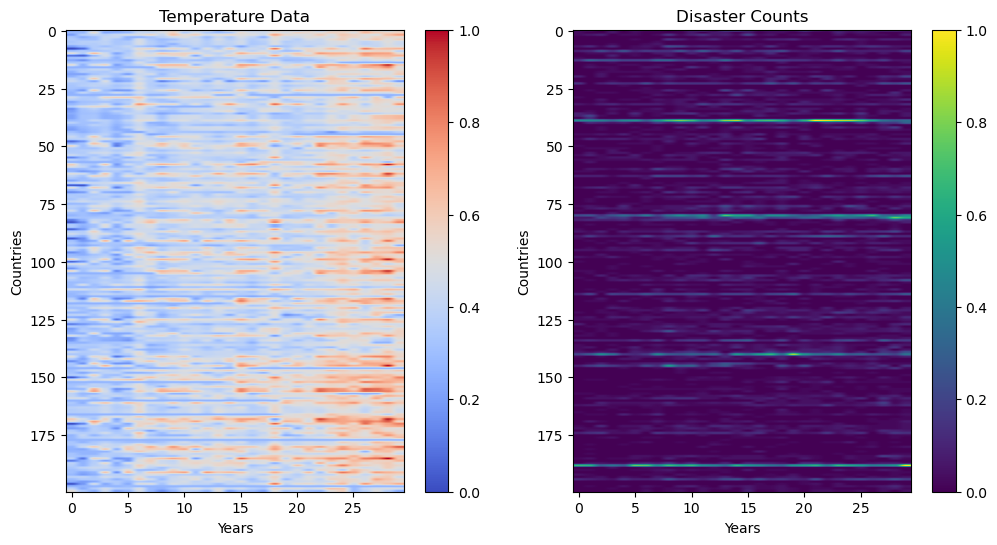

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize temperature data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(prev_years[0], cmap='coolwarm', aspect='auto')
plt.title('Temperature Data')
plt.colorbar()
plt.xlabel("Years")
plt.ylabel("Countries")


# Visualize disaster counts
plt.subplot(1, 2, 2)
plt.imshow(prev_years[1], cmap='viridis', aspect='auto')
plt.title('Disaster Counts')
plt.colorbar()
plt.xlabel("Years")
plt.ylabel("Countries")

plt.show()

## Quantum Neural Network (QNN) Definition

1. **Quantum Device Initialization:** The code begins by initializing a quantum device using PennyLane. The device is created with the "default.qubit" backend and has 10 qubits (quantum bits) and 10 classical bits. The quantum circuit is defined using a QuantumCircuit named `circuit`.

2. **Cost Function Definition:** A cost function is defined to combine the temperature and disasters data using user-defined alpha and beta weights. This cost function takes as input `x1` and `x2`, which are the results of quantum circuits, along with the training labels and the alpha and beta weights. It computes the distance between the quantum outputs and the training labels and returns a loss value.

3. **Quantum Circuit Definition:** A quantum circuit is defined using PennyLane. This circuit, named `quantum_circuit`, is designed to be part of a hybrid model. It takes an input `x` and a set of parameters `params`. Inside the circuit, quantum gates are applied to the qubits based on the `params`. The circuit computes the expectation values of Pauli-Z operators for each qubit and returns them as a list.

4. **Value Encoding Using Quantum Circuit:** A function named `encode_value` is defined to encode a value using the quantum circuit and parameters. It takes the PennyLane quantum circuit, data, and parameters as inputs. The data is converted to a binary representation, and the corresponding qubits are flipped based on this binary representation. The quantum circuit is then executed with the data and parameters, and the result is averaged and returned as a single value.

5. **Hybrid Model Definition:** A hybrid model is defined as a PyTorch neural network. The model has three fully connected layers (`fc1`, `fc2`, and `fc3`). Additionally, it has trainable parameters `q_params` for the quantum part of the model. The forward pass of the model includes processing the data through the classical layers and combining the classical and quantum outputs for each country.

The code sets up the infrastructure for a hybrid model that integrates both classical and quantum components for data processing and prediction.


In [4]:
# Define a quantum neural network (QNN) with temperature and disasters data
# Initialize a quantum device using PennyLane
dev = qml.device("default.qubit", wires=10)
qreg = QuantumRegister(10)
creg = ClassicalRegister(10)
circuit = QuantumCircuit(qreg, creg)

# Define a cost function that combines temperature and disasters data with alpha and beta weights
def cost_function(x1, x2, training_labels, alpha, beta):
    x1 = torch.tensor(x1, requires_grad=True)
    x2 = torch.tensor(x2, requires_grad=True)
    
    temperature_distance = torch.norm(x1 - training_labels[0])
    disaster_distance = torch.norm(x2 - training_labels[1])

    loss = torch.sqrt(alpha * temperature_distance + beta * disaster_distance)
    return loss

# Define a quantum circuit using PennyLane that will be part of the hybrid model
@qml.qnode(dev)
def quantum_circuit(x, params):
    for i in range(len(params)):
        qml.RY(params[i], wires=i)
    
    return [qml.expval(qml.PauliZ(i)) for i in range(10)]

# Encode a value using the quantum circuit and parameters
def encode_value(qml, data, params):
    frac_part = int((data) * 1000)
    bin_frac_part = format(frac_part, '02b')
    for i, bit in enumerate(bin_frac_part):
        if bit == '1':
            qml.x(qreg[i])  # Set the corresponding qubit to 1
    
    value = quantum_circuit(data, params)    
    return float(sum(value))/len(value)
                
# Define a Pennylane hybrid model that combines the quantum circuit and PyTorch model
class HybridModel(nn.Module):
    def __init__(self, input_size, num_qubits):
        super(HybridModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 16).to(torch.float64)
        self.fc2 = nn.Linear(16, 8).to(torch.float64)
        self.fc3 = nn.Linear(8, 1).to(torch.float64)

        # Initialize the trainable parameters for the VQC
        self.q_params = nn.Parameter(torch.randn(num_qubits), requires_grad=True)

    def forward(self, x):
        output = np.zeros(150)
        x1 = torch.relu(self.fc1(x))
        x2 = torch.relu(self.fc2(x1))
        classical_output = self.fc3(x2)
        
        for country in range(len(classical_output)):
            quantum_output = torch.tensor(encode_value(circuit, classical_output[country], self.q_params))
            output[country] = classical_output[country] + quantum_output

        return output

## Hybrid Model Training and Testing

1. **Input Size:** The code defines the `input_size` as 30, which represents the number of input features in the data.

2. **Training and Testing Function:** A function named `train_and_test_model` is defined to train and test the hybrid model. This function takes three parameters: `alpha` (a weight for temperature data), `beta` (a weight for disaster data), and `num_qubits` (the number of qubits in the quantum circuit).

3. **Model Initialization:** Inside the function, a `HybridModel` is instantiated with the specified `input_size` and `num_qubits`. Additionally, an Adam optimizer with a learning rate of 0.1 is created to optimize the model's parameters.

4. **Loss Calculation and Optimization:** The model is set to training mode with `model.train()`, and the gradients are zeroed using `optimizer.zero_grad()`. The model processes the training data, `training_data`, through its classical and quantum components. The results for temperature (`output_temp`) and disaster counts (`output_dist`) are computed and used to calculate the loss with the defined `cost_function`. The loss is then backward-propagated, and the model's parameters are updated with `optimizer.step()`.

5. **Quantum Parameters Optimization:** A separate optimizer, `optimizer_qparams`, is created for optimizing the quantum parameters (`model.q_params`) with a smaller learning rate. A specified number of optimization epochs (`num_qparams_epochs`) is used to fine-tune the quantum parameters.

6. **Model Evaluation:** The model is set to evaluation mode with `model.eval()`. A cumulative error variable, `cum_error`, is initialized to zero. Using a loop, the model processes the test data, `test_data`, and computes the predicted output. The Mean Squared Error (MSE) is calculated for each prediction, and the cumulative error is updated accordingly.

7. **MSE Calculation:** The calculated cumulative error is divided by 50 (the number of data points) to compute the final Mean Squared Error (MSE).

8. **MSE Reporting:** The MSE is printed to the console for evaluation.

This code defines a function to train and test the hybrid model under different parameter combinations and reports the MSE, providing insights into the model's performance.


In [5]:
    
input_size = 30

# Train and test the hybrid model with various combinations of alpha, beta, and the number of qubits
def train_and_test_model(alpha, beta, num_qubits):
    model = HybridModel(input_size, num_qubits)
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    criterion = nn.MSELoss()

    model.train()
    optimizer.zero_grad()

    output_temp = model(training_data[0])
    output_dist = model(training_data[1])

    output_temp = torch.tensor(output_temp, requires_grad=True)
    output_dist = torch.tensor(output_dist, requires_grad=True)
    loss = cost_function(output_temp, output_dist, training_labels, alpha, beta)

    loss.backward()
    optimizer.step()
            
    optimizer_qparams = optim.Adam([model.q_params], lr=0.01)
    num_qparams_epochs = 10  
    for epoch in range(num_qparams_epochs):
        model.train()
        optimizer_qparams.zero_grad()

        output_temp = model(training_data[0])
        output_dist = model(training_data[1])

        loss = cost_function(output_temp[:], output_dist[:], training_labels, alpha, beta)
        loss.backward()
        optimizer_qparams.step()

    model.eval()
    
    cum_error = 0
    with torch.no_grad():
        test_input = test_data[0]
        predicted_output = model(test_input)
        
    for i in range(50):
        error = (predicted_output[i].item()-test_labels[0,i])**2
        cum_error += error

    print(f"MSE: {(cum_error)/50}")

### Testing different alpha and beta values to determine which combination delivers the best results

In [6]:
# Train and test the hybrid model with different settings
train_and_test_model(1.0,1.0,10)
train_and_test_model(0.5,0.5,10)
train_and_test_model(0.1,0.1,10)

train_and_test_model(1.0,0.5,10)
train_and_test_model(1.0,0.1,10)

train_and_test_model(0.5,1.0,10)
train_and_test_model(0.5,0.1,10)

train_and_test_model(0.1,1.0,10)
train_and_test_model(0.1,0.5,10)

C:\Users\User\AppData\Local\Temp\ipykernel_18316\2118641482.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x1 = torch.tensor(x1, requires_grad=True)
C:\Users\User\AppData\Local\Temp\ipykernel_18316\2118641482.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(x2, requires_grad=True)


MSE: 0.0826671790600494
MSE: 0.150384361196006
MSE: 0.1270070067984308
MSE: 0.18309950295293467
MSE: 0.16099094539694622
MSE: 0.09811614033084132
MSE: 0.22533076564760746
MSE: 0.05038763780789028
MSE: 0.05017478648168594


### Code Summary

- The code loads temperature change and disaster count data from CSV files.
- It normalizes the data and visualizes it using heatmaps.
- A hybrid model is defined, combining a quantum circuit with PyTorch components.
- The model is trained and tested with different combinations of alpha, beta, and the number of qubits.
- Mean squared error (MSE) is computed to evaluate the model's performance.
